<a href="https://colab.research.google.com/github/andrew-veriga/MathForML/blob/master/ConvolutionalCoffieCircles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load libs

In [1]:
import tensorflow as tf
import numpy as np

### Load picture

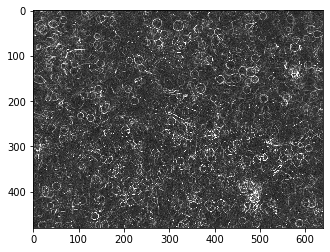

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path='https://github.com/andrew-veriga/MathForML/blob/master/CoffieCircles.png?raw=true'
Image = mpimg.imread(img_path)
plt.imshow(Image)

In [3]:
print(Image.shape)

(480, 640, 4)


###Prepare picture
Convert Image to 2D

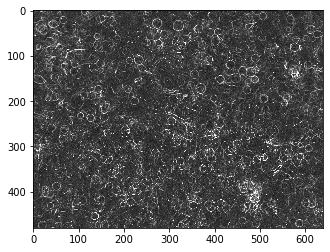

In [4]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

Image = rgb2gray(Image)    
plt.imshow(Image, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)

In [5]:
print (Image.shape)

(480, 640)


###Init variables

`MaxSize` - max size of square region

`MinSize` - min size of square region

`Contrast` - scalar set contrast of recognizing ring 
`Thick` - thickness of ring
`FoundCircles` - numpy array of centers and radiuces (3,None)

In [0]:
firstX=1
firstY=1
ImageSize = (48,90) #Image.shape
MaxSize = 40 
MinSize = 10
Contrast = .18
Variance = 0.03
Thick = .8
FoundCircles = np.array([0,3])
_DEBUG_=False

In [0]:
# from scipy.spatial import distance
# for i in range(0,a.shape[0]):
#   d = [np.sum((a[i]-a[j])**2) for j in range(i+1,a.shape[0])] 
#   print(d) 

###function isCircleFound
calculate average brightness over all pixels of current square;
If pixels of SelectedRing have avg brightness more then avg brightness over all square - circle is found 


In [0]:
#from scipy.special import softmax

def isCircleFound(_box, _mask):
  
  brightness = (lambda arr: np.average(arr-np.min(_box)))#/(np.max(arr)-np.min(box))))
  if _DEBUG_:
    print ('ring brightness', brightness(_box[_mask]))
    print ('back brightness', brightness(_box[~_mask]))
    print('ring variance', np.var(_box[_mask]))
  return ((brightness(_box[_mask]) - brightness(_box[~_mask])) > Contrast and np.var(_box[_mask]) < Variance)
  

###function getMask
create square matrix of boolean as a ring of Trues inscribed in a square of Falses

False


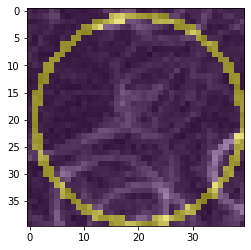

In [9]:
import itertools

def getMask( size, thick = 1 ):
    radius = size //2 - 1
    center = np.array([size/2,size/2])
    vectors = [[(i,j) for j in range(size)] for i in range(size)]
    l = itertools.chain.from_iterable(zip(*vectors))
    
    # list of pairs (x,y) belong of ring
    selectedVecs = np.array(list(filter(lambda v: np.abs(np.linalg.norm(v - center) - radius) < thick,l)))
    
    #ring mask
    ring = np.array(np.zeros((size,size),dtype=np.bool))
    for (i,j) in (selectedVecs):
      ring[i,j]=True
    
    return ring

Mask = getMask( MaxSize, .8 )
square = Image[firstY:firstY+MaxSize, firstX:firstX+MaxSize]
    
#ring visualisation
fig, ax = plt.subplots()
ax.imshow(square, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax.imshow(getMask( MaxSize, .8 ),alpha=.5)
fig.show()
print (isCircleFound(square, Mask))

### function FuzzyCircleConv

In [0]:
import numpy.ma as ma

def FuzzyCircleConv(_box, _mask):
  # return sum(np.dot(_box,_mask))
  mlt = np.multiply(_box,_mask)
  return np.sum(mlt)#/ np.var(ma.masked_values(mlt, 0.0 ))
  

###function getKernel

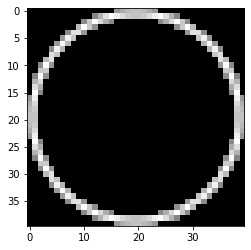

In [11]:
import itertools
import numpy as np
import random as rn
    # size=40 
    # thick = 1
MaxPix = np.max(Image)
MinPix = np.min(Image)

def getKernel( size, thick = 1. ):
    radius = size //2-1
    center = np.array([size/2-.5,size/2-.5])
    vectors = [[(i,j, thick - np.abs(np.linalg.norm((i,j) - center) - radius)) for j in range(size)] for i in range(size)]
    l = itertools.chain.from_iterable(zip(*vectors))
    
    # list of pairs (x,y) belong of ring
    selectedVecs = np.array(list(filter(lambda v: v[2] > 0. ,l)))
    #ring mask
    ring = np.ones((size,size), dtype=np.float32) #np.random.rand(size,size)
    # print(selectedVecs.T[2])
    # print(np.max(selectedVecs.T[2]))
    maxMask= np.max(selectedVecs.T[2])
    ring = -(ring - MinPix)/(MaxPix-MinPix)
    
    for (i,j,k) in (selectedVecs):
      ring[np.int(i),np.int(j)]=k/maxMask

    return ring
plt.imshow(getKernel(40,1),cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)


###One example of arbitrary ring

Conv value: -0.23938815451312112


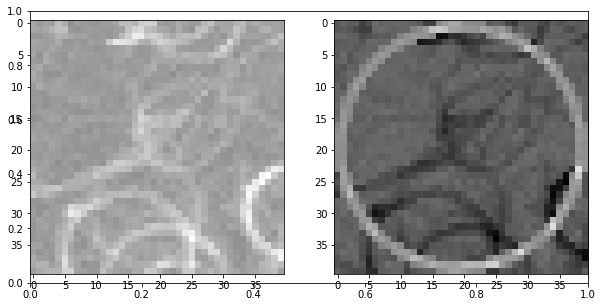

In [12]:
Mask = getKernel( MaxSize, 1 )
square = Image[firstY:firstY+MaxSize, firstX:firstX+MaxSize]
    
#ring visualisation
#ring visualisation
fig, ax = plt.subplots(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.imshow(square, cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)

ax1=fig.add_subplot(1,2,2)

ax1.imshow(np.multiply(square,Mask), cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)
fig.show()
print('Conv value:',FuzzyCircleConv(square,Mask)/MaxSize**2)


###Some examples of founded ring

ring brightness 0.14744349608334403
back brightness 0.1390943346788622
ring variance 0.017996583460026267
founded False
ring brightness 0.33639774050121013
back brightness 0.13414275252232657
ring variance 0.0269366493076894
founded True
ring brightness 0.36114036549853157
back brightness 0.17395765442582778
ring variance 0.03465650608141917
founded False
ring brightness 0.2860008193409443
back brightness 0.17008103641723282
ring variance 0.022180240790188717
founded False


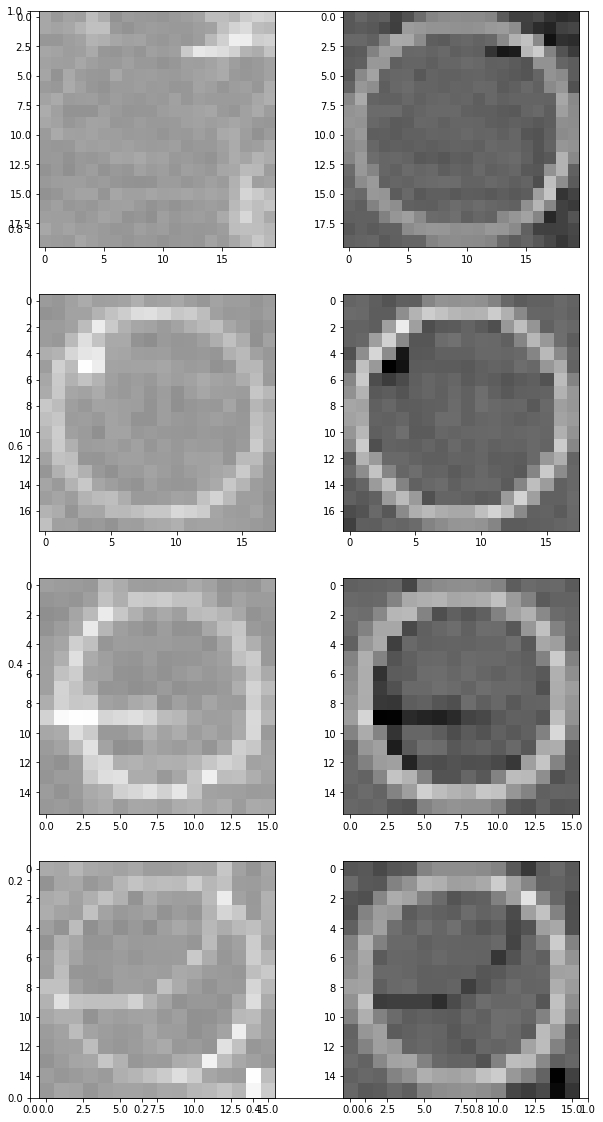

In [86]:
#1. SquareSize=18, (x,y)= 58, 13
#2. SquareSize=16, (x,y)=133,50
Contrast = .18
Variance = 0.03
data=np.array([
      [20,1,1],
      [18, 58, 13],
      [16, 133, 50],
      [16, 138, 76]
      ])
# x=58
# y=13
# size=18
# x1=133
# y1=50
# size1=16
len = data.shape[0]
fig, ax = plt.subplots(figsize=(10,5*len))
i=1
for size,x,y in data:
  Mask = getKernel( size, 1 )
  square = Image[y:y+size, x:x+size]
  #ring visualisation
  ax = fig.add_subplot(len,2,i)
  ax.imshow(square, cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)    
  ax1=fig.add_subplot(len,2,i+1)
  ax1.imshow(np.multiply(square,Mask), cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)
  _DEBUG_=True
  # print('conv value', FuzzyCircleConv(Mask,square)/size**2)
  print('founded', isCircleFound(square,getMask(size)))
  i+=2

fig.show()

_DEBUG_=False

In [74]:
data.shape
len

3

###Try classic convolutions

conv value -0.12937657019172136
-0.12937657019172139


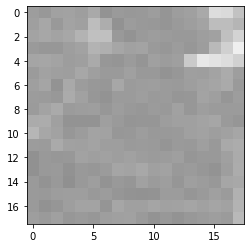

In [14]:
  
  SquareSize=18
  Thick=1
  kernel=getKernel( SquareSize, Thick )
  kernel_size =kernel.shape[0]
  pad_size = kernel_size // 2
  rest = kernel_size % 2
  horisontal_pad = np.random.rand(ImageSize[0], pad_size)#, dtype=np.float64)
  vertical_pad = np.zeros((pad_size, ImageSize[1]+pad_size*2), dtype=np.float64)
  a = np.hstack((horisontal_pad, Image[:ImageSize[0],:ImageSize[1]], horisontal_pad))
  a = np.vstack((vertical_pad, a, vertical_pad))

  sub_shape = kernel.shape
  view_shape = (ImageSize[0]+ rest,ImageSize[1]+ rest, sub_shape[0] , sub_shape[1] )
  strides = a.strides + a.strides
  sub_matrices = np.lib.stride_tricks.as_strided(a,view_shape,strides)
  #arbirtary region
  square = sub_matrices[pad_size,pad_size,:,:]
  plt.imshow(square,plt.get_cmap('gray'), vmin=-1, vmax=1)
  print('conv value', FuzzyCircleConv(square,kernel)/kernel_size**2)
  m=np.sum(np.multiply(sub_matrices,kernel), axis=(2,3))/(kernel_size**2)
  # m = np.sum(np.multiply(square))/(kernel_size**2)
  print(m[pad_size,pad_size])  

In [15]:
sub_matrices.shape

(48, 90, 18, 18)

conv value -0.08034258328586487
-0.08034258328586488


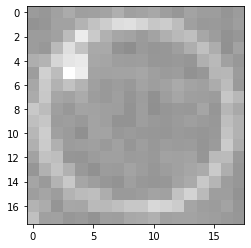

In [16]:
#founded ring
square = sub_matrices[pad_size+13,pad_size+58,:,:]
plt.imshow(square,plt.get_cmap('gray'), vmin=-1, vmax=1)
print('conv value', FuzzyCircleConv(square,kernel)/kernel_size**2)
m=np.sum(np.multiply(sub_matrices,kernel), axis=(2,3))/(kernel_size**2)

print(m[pad_size+13,pad_size+58])

In [17]:
sub_matrices.shape


(48, 90, 18, 18)

In [0]:
#https://stackoverflow.com/questions/43086557/convolve2d-just-by-using-numpy
def conv(_kernel):
  # _kernel = getKernel( size, Thick )
  kernel_size = _kernel.shape[0]
  pad_size = kernel_size // 2
  rest = 0#kernel_size % 2
  horisontal_pad = np.random.rand(ImageSize[0], pad_size)#, dtype=np.float64)
  vertical_pad = np.random.rand(pad_size, ImageSize[1]+pad_size*2)#, dtype=np.float64)
  a = np.hstack((horisontal_pad, Image[:ImageSize[0],:ImageSize[1]], horisontal_pad))
  a = np.vstack((vertical_pad, a, vertical_pad))

  sub_shape = (_kernel.shape)
  view_shape = (ImageSize[0]+ rest,ImageSize[1]+ rest, sub_shape[0] , sub_shape[1] )
  strides = a.strides + a.strides
  sub_matrices = np.lib.stride_tricks.as_strided(a,view_shape,strides)


  # m=np.sum(np.multiply(sub_matrices,_kernel), axis=(2,3))/(kernel_size**2)
  m = np.einsum('ij,klij->kl',_kernel,sub_matrices)/kernel_size**2
  return m
  

### try masqueraded convolutions

In [19]:
mask = getMask( 18, 1 )
print(np.average(sub_matrices[:,:,mask],axis=2).shape)
print(np.min(sub_matrices,axis=(2,3)).shape)

(48, 90)
(48, 90)


In [0]:
ImageSize=Image.shape

In [0]:
#https://stackoverflow.com/questions/43086557/convolve2d-just-by-using-numpy
def mask_conv(_mask):
  # _mask = getKernel( size, Thick )
  mask_size = _mask.shape[0]
  pad_size = mask_size // 2
  rest = 0#mask_size % 2
  horisontal_pad = np.random.rand(ImageSize[0], pad_size)#, dtype=np.float64)
  vertical_pad = np.zeros((pad_size, ImageSize[1]+pad_size*2), dtype=np.float64)
  a = np.hstack((horisontal_pad, Image[:ImageSize[0],:ImageSize[1]], horisontal_pad))
  a = np.vstack((vertical_pad, a, vertical_pad))

  sub_shape = (_mask.shape)
  view_shape = (ImageSize[0]+ rest,ImageSize[1]+ rest, sub_shape[0] , sub_shape[1] )
  strides = a.strides + a.strides
  sub_matrices = np.lib.stride_tricks.as_strided(a,view_shape,strides)
  
  brightness = (lambda arr, msk: np.average(arr[:,:,msk],axis=2)-np.min(arr,axis=(2,3)))#/(np.max(arr)-np.min(box))))
  
  m = np.logical_and(np.greater((brightness(sub_matrices,_mask) - brightness(sub_matrices,~_mask)),Contrast), np.less(np.var(sub_matrices[:,:,_mask],axis=2), Variance)) #/ np.var(sub_matrices,axis=(2,3)) # > Contrast #and np.var(_box[_mask]) < Variance):
  

  # m=np.sum(np.multiply(sub_matrices,_mask), axis=(2,3))/(mask_size**2)
  # m = np.einsum('ij,klij->kl',_mask,sub_matrices)/mask_size**2
  return m
  

In [48]:
MinSize=13
ConvMatrices = np.empty((0,ImageSize[0],ImageSize[1]))
for size in range(MinSize,MaxSize):
  mask = getMask( size, 1 )
  #print('size '+str(size))
  res = mask_conv(mask)
  ConvMatrices= np.concatenate((ConvMatrices, np.reshape(res,(1,ImageSize[0],ImageSize[1]))),axis=0)

  # x=58
  # y=13
  # size=18
  # Thick= 1
  # conv value -0.08034258328586487
print(ConvMatrices[18-MinSize,pad_size+12,pad_size+57])
print(ConvMatrices[18-MinSize,pad_size,pad_size])
# for y in range(0,ImageSize[0]-size):
    # for x in range(0, ImageSize[1] - size):
    #   square = Image[y:y+size, x:x+size]
    #   ConvMatrices[y,x, size - MinSize] = FuzzyCircleConv(square,mask)
    #   # fig, ax = plt.subplots()
    #   # ax = fig.add_subplot(1,2,1)
    #   # ax.imshow(square, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    #   # ax1=fig.add_subplot(1,2,2)
    #   # ax1.imshow(square, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    #   # ax1.imshow(mask,alpha=.5)
    #   # fig.show()
    #   # print([(x,y),size])
      

    

1.0
0.0


In [32]:
print(ConvMatrices.shape)

(22, 480, 640)


In [0]:
# outfile = TemporaryFile()
np.save('ConvMatrices', ConvMatrices)

### Main loops


size:  13
size:  14
size:  15
size:  16
606 125 1.0
551 184 1.0
552 184 1.0
size:  17
551 183 1.0
551 184 1.0
size:  18
57 12 1.0
58 12 1.0
57 13 1.0
58 13 1.0
81 125 1.0
80 126 1.0
81 126 1.0
39 139 1.0
550 184 1.0
215 191 1.0
506 223 1.0
size:  19
57 12 1.0
57 13 1.0
382 39 1.0
597 111 1.0
80 125 1.0
80 126 1.0
38 138 1.0
38 139 1.0
214 191 1.0
505 222 1.0
165 300 1.0
size:  20
382 38 1.0
382 39 1.0
481 95 1.0
80 125 1.0
498 185 1.0
499 185 1.0
size:  21
480 95 1.0
461 164 1.0
498 184 1.0
498 185 1.0
size:  22
size:  23
size:  24
308 21 1.0
435 137 1.0
size:  25
308 21 1.0
434 137 1.0
size:  26
size:  27
size:  28
size:  29
size:  30
size:  31
size:  32
size:  33
size:  34
size:  35
size:  36
size:  37
size:  38
size:  39


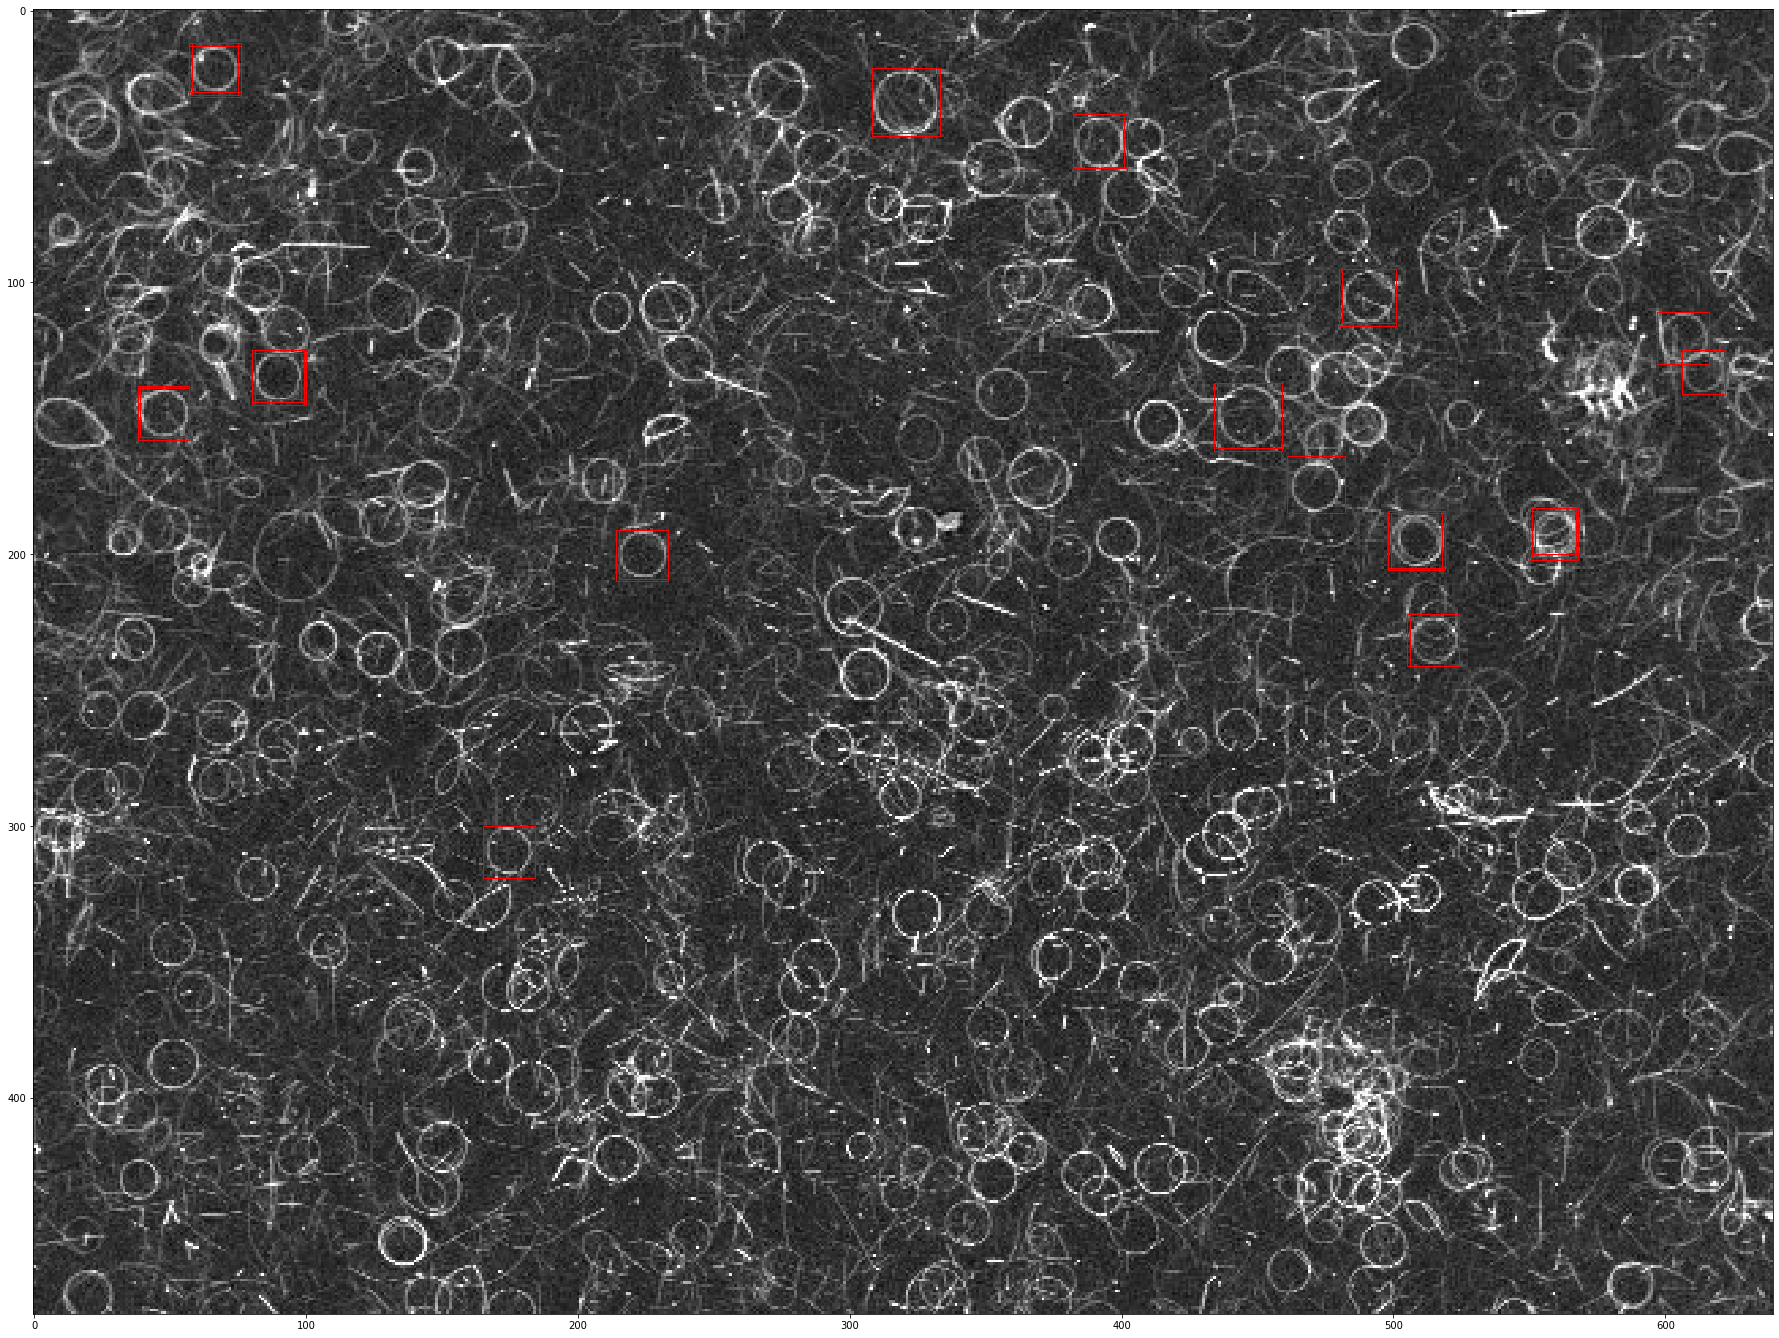

In [49]:
Contrast=0.17
import matplotlib.patches as patches
# plt.ioff()
fig, ax = plt.subplots(figsize=(32, 24))
ax.imshow(Image,cmap=plt.get_cmap('gray') )
# Create a Rectangle patch

cnt=0
for size in range(MinSize,MaxSize):
  print('size: ',size)
  convs = ConvMatrices[size-MinSize,size//2:-size//2,size//2:-size//2]
  for i in range(size//2,convs.shape[0]-size//2):
    y= i 
    for j in range(size//2, convs.shape[1]-size//2):
      x = j 
      if (convs[i,j]):
        print(x, y, convs[i,j])
        cnt+=1
        if (cnt>50):
          break
        rect = patches.Rectangle((x,y),size,size,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
plt.show()